problem to solve:
a) store houses data from different pages ---> understand where we'll store tha pages
d) jaccard similarity
e) draw wordcloud
f) comments

In [32]:
import os
from bs4 import BeautifulSoup
import pandas as pd
import requests
from requests import get
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import RegexpTokenizer
from math import log
from math import sqrt
import re
from collections import Counter
from time import sleep
from random import randint
from warnings import warn
import numpy as np
from IPython.core.display import clear_output
from time import time
import sklearn
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from sklearn.metrics import jaccard_similarity_score
import matplotlib.pyplot as plt
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [33]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Giumas\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [34]:
pages = [str(i) for i in range(1,20)]

In [35]:
# Lists to store the scraped data int
prices = []
locals_ = []
surfaces = []
bathrooms = []
floors = []
descriptions = []

In [47]:
# Preparing the monitoring of the loop
start_time = time()
requests = 0

for page in pages:
    url = ('https://www.immobiliare.it/vendita-case/roma/?criterio=rilevanza&pag=' +page)
    response = get(url)
    # Pause the loop
    sleep(randint(8,15))
    # Monitor the requests
    requests += 1
    elapsed_time = time() - start_time
    print('Request:{}; Frequency: {} requests/s'.format(requests, requests/elapsed_time))
    clear_output(wait = True)
    # Throw a warning for non-200 status codes
    if response.status_code != 200:
        warn('Request: {}; Status code: {}'.format(requests, response.status_code))
    # Break the loop if the number of requests is greater than expected
    if requests > 10000:
        warn('Number of requests was greater than expected.')  
        break
    # Parse the content of the request with BeautifulSoup
    page_html = BeautifulSoup(response.text, 'html.parser')
    try :
    # Select all the houses contained from a single page
        house_containers = page_html.find_all('div', class_ = 'listing-item_body--content')
        for house in house_containers:
            house.find('li', class_ = '"lif__item lif__pricing')
            locals_surface_bathrooms = house.findAll('span', class_="text-bold")
            filtering_floor= house.findAll('abbr', class_="text-bold im-abbr") 
    # If the house has all info that need us (price, locals, surface, bathroom and floor) then extract:
        if len(locals_surface_bathrooms) == 3 :
            if len(filtering_floor) >= 1: 
                floor = house.find('abbr', class_="text-bold im-abbr").text.strip()
                if  floor != 'A' and floor != 'S' and floor != 'T':  #don't take houses with A,S,T value for the floor

        # The price
                          price = house.find('li', class_="lif__item lif__pricing").text.strip()
                          #if condition needs us to know if price has got also old price (in this case price has % character)
                          if '%' in price : 
                              price = house.find('div').text.strip()
                          price = re.sub('[€] ', '', price)
                          price = re.sub('[.]', '', price)
                          price = int(price)
                          prices.append(price)

        #the number of locals, surface (m^2), and number of bathrooms
                          local_ = locals_surface_bathrooms[0].text.strip()
                          if '+' in local_:
                              local_ = re.sub('[+]', '', local_)
                          locals_.append(int(local_))
                          surface = locals_surface_bathrooms[1].text.strip()
                          surfaces.append(int(surface))
                          bathroom = locals_surface_bathrooms[2].text.strip()
                          if '+' in bathroom:
                              bathroom = re.sub('[+]', '', bathroom)
                          bathrooms.append(int(bathroom))
        
        #the floor
                          floors.append(int(floor))

        # the description
                          description = house.find('p', class_="descrizione__truncate").text.strip()
                          descriptions.append(description)
    except :
        pass

Request:19; Frequency: 0.07686629416625183 requests/s


In [49]:
len(prices)

26

In [56]:
prices2 = prices[:18]
locals2 = locals_[:18]
surfaces2 = surfaces[:18]
bathrooms2 = bathrooms[:18]
floors2 = floors[:18]
descriptions2 = descriptions[:18]

In [58]:
info_matrix = pd.DataFrame({'price':prices2,
                           'locals':locals2,
                           'surface':surfaces2,
                           'bathroom':bathrooms2,
                           'floor': floors2})
info_matrix.to_csv("firstMatrix.csv")
info_matrix1 = pd.read_csv("firstMatrix.csv")

In [59]:
info_matrix

,price,locals,surface,bathroom,floor
0,1650000,5,220,3,4
1,1050000,5,290,2,2
2,275000,3,72,1,3
3,620000,2,65,1,2
4,230000,3,105,2,4
5,560000,2,60,2,3
6,449000,2,93,1,4
7,720000,3,115,2,1
8,189000,3,79,1,2
9,590000,5,152,3,4


Let's to cleaning houses description

In [60]:
def clening_description(description):  # use all the techniques to remove unwanted items from words
    
    tokenizer = RegexpTokenizer(r'\w+')
    ps = PorterStemmer()
    # Remove "\\n" and replace with a space
    description = description.replace("\\n", " ")
    # Convert everything to lowercase
    description = description.lower()
    # Removing punctuation
    description = tokenizer.tokenize(description)
    # Stemming (TOGLIERE TOGLIERE TOGLIERE è INUTILE)
    description = [ps.stem(word) for word in description]
    # Removing stopwords
    description = [word for word in description if word not in stopwords.words('italian')]
    # No integers
    description = [x for x in description if not (x.isdigit() or x[0].isdigit())]
    return description

In [145]:
cleaned_descriptions = []
for description in descriptions:
    cleaned_description = clening_description(description)
    cleaned_descriptions.append(' '.join(cleaned_description))
    
    

In [146]:
cleaned_descriptions

['pochi passi villa pamphili precisament via piccolomini vie eleganti prestigios capital proponiamo vendita esclusivo attico panoramico ca coperti terrazza livello oltr vista suggestiva cupola san pietro ampio ingresso acced ambienti salon doppi',
 'balduina appartamento vendita adiacenz piazza balduina libero luminoso finement ristrutturato ingresso salon camera possibilità camera cucina abitabil arredata bagno balcon cantina dilazioni permut rif tel balduina apart for sale adjac piazza balduina free bright tast renov',
 'via banchi nuovi via banchi nuovi bellissimo palazzo ascensor proponiamo vendita appartamento molto luminoso terzo piano completament ristrutturato ingresso cucina vista camera pranzo salotto camera letto spogliatoio bagno riscaldamento autonomo aria condizionata immobil attualmen',
 'casalpalocco appartamento proprietà proposta vendita compon appartamento piano secondo monolocal piano terra total circa mq interni completo giardino secondo piano senza ascensor acced 

In [62]:
corpus = [y for x in cleaned_descriptions for y in x]

#all words present in all descriptions

In [63]:
count_corpus = Counter(corpus)
count_corpus= dict(count_corpus.most_common())

final_dict = {str(i+1):x for i,x in enumerate(count_corpus)}
final_dict_inv = {str(x):(i+1) for i,x in enumerate(count_corpus)}

In [64]:
indx = {}
for n,document in enumerate(cleaned_descriptions):
    new_document = []
    for word in document:
        new_document.append(final_dict_inv[str(word)])
    indx[str(n+1)] = new_document 
    
inv_indx = {str(i):[] for i in list(final_dict.keys())}
for word in list(final_dict.keys()):
    for i in range(len(indx)):
        if int(word) in indx[str(i+1)]:
            inv_indx[word].append(i+1)

In [76]:
houses_count= len(info_matrix)

In [78]:
inv_indx2 = {i:[] for i in list(final_dict.keys())}
for word in list(final_dict.keys()):
    for i,l in enumerate(list(indx.values())):
        if int(word) in l:
            tf = l.count(int(word))/len(l)
            id_f = log(houses_count/len(inv_indx[word]))
            inv_indx2[word].append((i+1,tf*id_f))

In [80]:
converting = [(k, *t) for k, v in inv_indx2.items() for t in v ]


In [81]:
test = pd.DataFrame(converting, columns=['Word', 'Document', 'Tf-Idf'])

In [95]:
matrix_tfidf = test.pivot_table(index = 'Document', columns = 'Word', values='Tf-Idf', fill_value = 0)[:18]

In [96]:
matrix_tfidf.head()

Word,1,10,100,101,102,103,104,105,106,107,...,90,91,92,93,94,95,96,97,98,99
Document,,,,,,,,,,,,,,,,,,,,,
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,-0.005574,0.011263,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.061034,0.061034,0.061034,0.061034,0.061034,0.000000,0.000000,0.000000,0.000000,0.000000
3,-0.005902,0.011925,0.064624,0.064624,0.064624,0.064624,0.064624,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.064624,0.064624,0.064624,0.064624,0.064624
4,-0.018813,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.068663,0.068663,0.068663,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,-0.005733,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


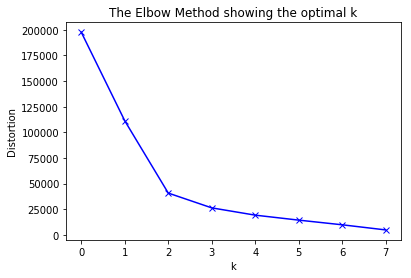

In [97]:
# k means determine k for first matrix ( mettiamo 10 a range(2,10)) (QUA HO CAMBIATO!!!! NON C'è PIù K= RANGE ETCT)
distortions = []
for k in range(2,10):
    kmeanModel = KMeans(n_clusters=k, init='k-means++').fit(info_matrix)
    kmeanModel.fit(info_matrix)
    distortions.append(sum(np.min(cdist(info_matrix, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / info_matrix.shape[0])

# Plot the elbow
plt.plot( distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

The elbow matrix shows that the better number of cluster for the first matrix is 5 (the point where the plot starts the "elbow")

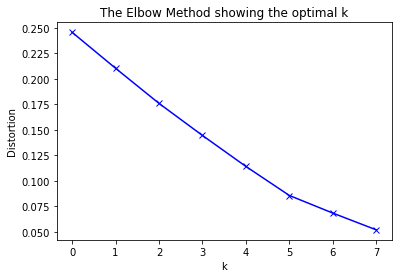

In [98]:
# k means determine k for second matrix (ANCHE QUA HO CAMBIATO)
distortions = []
for k in range(2,10):
    kmeanModel = KMeans(n_clusters=k, init='k-means++').fit(matrix_tfidf)
    kmeanModel.fit(matrix_tfidf)
    distortions.append(sum(np.min(cdist(matrix_tfidf, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / info_matrix.shape[0])

# Plot the elbow
plt.plot( distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

The elbow matrix shows that there'is a visible better number of cluster for the second matrix. So we choise to deal with 10 clusters

In [99]:
# kmeans++ clustering for first matrix with k = 5 (choosen with elbow method)
cluster = sklearn.cluster.KMeans(n_clusters=5, init='k-means++').fit(info_matrix)
labels = cluster.labels_

In [100]:
# kmeans++ clustering for second matrix with k = 4 (choose with elbow method)
cluster2 = sklearn.cluster.KMeans(n_clusters=4, init='k-means++').fit(info_matrix)
labels2 = cluster2.labels_

Let's add label column to both matrixs to know the number of cluster for each announcement and for each document

In [101]:
labels_se = pd.Series(labels)
info_matrix['labels'] = labels_se.values
info_matrix.head()

,price,locals,surface,bathroom,floor,labels
0,1650000,5,220,3,4,3
1,1050000,5,290,2,2,1
2,275000,3,72,1,3,0
3,620000,2,65,1,2,2
4,230000,3,105,2,4,0


In [102]:
len(matrix_tfidf)

18

In [103]:
labels2_se = pd.Series(labels2)
matrix_tfidf['labels2'] = labels2_se.values
matrix_tfidf.head()

Word,1,10,100,101,102,103,104,105,106,107,...,91,92,93,94,95,96,97,98,99,labels2
Document,,,,,,,,,,,,,,,,,,,,,
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1
2,-0.005574,0.011263,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.061034,0.061034,0.061034,0.061034,0.000000,0.000000,0.000000,0.000000,0.000000,3
3,-0.005902,0.011925,0.064624,0.064624,0.064624,0.064624,0.064624,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.064624,0.064624,0.064624,0.064624,0.064624,0
4,-0.018813,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.068663,0.068663,0.068663,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2
5,-0.005733,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0


Ora bisogna calcolare il jaccard similarity tra coppie di cluster. La colonna label e labels2 servono a specificare, per ogni riga,
a quale cluster appartiene (per la prima matrice da 0 a 4 (i cluster sono 5), seconda i cluster vanno da 0 a 19 (i cluster sono 20)).
La jaccard va calcolata tra coppie di cluster appartenenti alle due matrici: quindi tra cluster 0 della matrice 1 e cluster 0 della matrice 2, ecc ecc.

In [105]:
sims = {}
for i,label in enumerate(info_matrix['labels']):
    if label not in sims:
        sims[label] = [i+1]
    if label in sims:
        sims[label].append(i+1)
sims2 = {}
for i,label in enumerate(matrix_tfidf['labels2']):
    if label not in sims2:
        sims2[label] = [i+1]
    if label in sims2:
        sims2[label].append(i+1)

Una volta calcolata la jaccard va fatto il word cloud, inserito qualche commento e il nostro lavoro è terminato!

In [112]:
keypair= {}
for clust in sims:
    for clust2 in sims2:
        keypair[str(clust),str(clust2)]= len(set.intersection(set(sims[clust]),set(sims2[clust2])))/len(set.union(set(sims[clust]),set(sims2[clust2])))

In [133]:
descriptions

['A pochi passi da Villa Pamphili, e precisamente in via Piccolomini, una delle vie più eleganti e prestigiose della Capitale, proponiamo in vendita un esclusivo attico panoramico di ca. 200mq coperti con terrazza a livello di oltre 100mq con vista suggestiva sulla Cupola di San Pietro. Dall’ampio ingresso si accede a tutti gli ambienti: salone doppi...',
 'Balduina, Appartamento in vendita adiacenze Piazza della Balduina, libero luminoso finemente ristrutturato ingresso salone camera (possibilità 2^ camera) cucina abitabile arredata bagno balcone e cantina. \nDilazioni - Permute Rif 1034M - TEL. 06.5343497\n\n\nBalduina, Apartment for sale, adjacency Piazza della Balduina free bright tastefully renovated...',
 "VIA DEI BANCHI NUOVI \nIn Via dei Banchi Nuovi in un bellissimo palazzo dell'800 con ascensore proponiamo la vendita di un appartamento molto luminoso al terzo piano completamente ristrutturato. Ingresso, cucina a vista e camera da pranzo, salotto, camera da letto, spogliatoio,

In [120]:
highest3 = sorted(keypair.values(), reverse = True)[:3]

In [125]:
clust3 = []
for key in keypair:
    if keypair[key] in highest3:
        clust3.append(key)

In [126]:
clust3

[('3', '1'), ('1', '3'), ('0', '0')]

In [130]:
cloud=[]

for tuple_ in clust3:
    announcements = []
    for i,clust in enumerate(info_matrix['labels']):
        if int(tuple_[0]) == clust:
            announcements.append(i+1)
    for i,clust in enumerate(matrix_tfidf['labels2']):
        if int(tuple_[1]) == clust:
            announcements.append(i+1)
    cloud.append(announcements)


In [147]:
couple_desc = []
for couple in cloud:
    descs = []
    for idx in couple:
        descs.append(cleaned_descriptions[idx])
    couple_desc.append(''.join(descs))

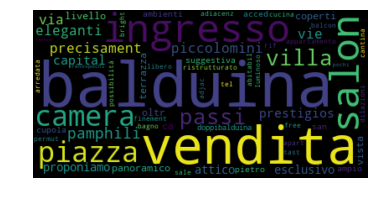

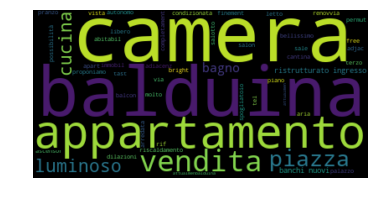

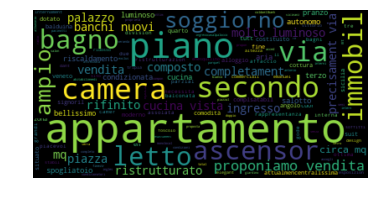

In [148]:


# Create and generate a word cloud image:
for desc in range(len(couple_desc)):
    wordcloud = WordCloud().generate(couple_desc[desc])

# Display the generated image:
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()